In [41]:
# from PIL import Image
%matplotlib inline
import regex
import pytesseract as pt
from pytesseract import Output

import cv2
from matplotlib import pyplot as plt

# Optical Character Recognition
Saketh Raman KS (19PW26)

Sanjay T (19PW28)

In [1]:
import os

IMAGE_FORMATS = ('.png', '.jpg', '.jpeg')

def get_image_files(path):
  files = os.listdir(path)
  imgFiles = [ x for x in files if x.lower().endswith(IMAGE_FORMATS) ]
  return imgFiles

def clear_folder(folder):
  for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    os.unlink(file_path)
  

## Stage 1 - Detection of license plates

In [8]:

from imageai.Detection import ObjectDetection
import copy

YOLO_PATH = "./Models/yolo.h5"

class ObjectDetector:
    def __init__(self, input_path, output_path, min_prob):
        self.input_path = input_path
        self.output_path = output_path
        self.detector = ObjectDetection()
        self.min_prob = min_prob
        self.detections = {}
        
        self.detector.setModelTypeAsYOLOv3()
        self.detector.setModelPath(YOLO_PATH)

    def detect(self):
        self.detector.loadModel()
        clear_folder(self.output_path)
        
        for imgFile in get_image_files(self.input_path):
            input_image = os.path.join(self.input_path, imgFile)
            output_image = os.path.join(self.output_path, imgFile)
            det = self.detector.detectObjectsFromImage(input_image=input_image, output_image_path=output_image, minimum_percentage_probability=self.min_prob)
            self.detections[input_image] = det
    
    def get_detections(self):
        return self.detections
    
    def get_detection_labels(self):
        detected_labels = {}
        for file, detection in self.detections.items():
            labels = []
            for detection_dict in detection:
                labels.append(detection_dict["name"])
            
            detected_labels[file] = copy.deepcopy(labels)
        
        return detected_labels

In [10]:
carInputPath = "./Data/Image/Input"
carLabelledPath = "./Data/Image/Labelled"

objDet = ObjectDetector(carInputPath, carLabelledPath, 50)
objDet.detect()
detections = objDet.get_detection_labels()
print(detections)

{'./Data/Image/Input/car2.jpg': ['car', 'truck'], './Data/Image/Input/car3.jpg': ['car', 'car', 'car'], './Data/Image/Input/car4.jpeg': ['car'], './Data/Image/Input/car5.jpg': ['car', 'car'], './Data/Image/Input/car1.jpg': ['car', 'car', 'car', 'car', 'car'], './Data/Image/Input/car6.jpeg': ['car'], './Data/Image/Input/car7.jpg': ['car'], './Data/Image/Input/bus1.jpg': ['bus', 'person', 'person', 'person', 'person'], './Data/Image/Input/car8.jpeg': ['car', 'car', 'truck', 'bus', 'person'], './Data/Image/Input/car9.jpeg': ['car', 'motorcycle'], './Data/Image/Input/street1.jpg': [], './Data/Image/Input/street2.jpg': ['traffic light'], './Data/Image/Input/street3.jpg': []}


Filtering

The image files which contain relevant labels are filtered and copied to a different location

In [13]:
FILTER_LABELS = ("car", "bus", "truck", "motorcycle")

filtered_files = []
for file, file_labels in detections.items():
  for filter_label in FILTER_LABELS:
    if filter_label in file_labels:
      filtered_files.append(file)
      break

['./Data/Image/Input/car2.jpg', './Data/Image/Input/car3.jpg', './Data/Image/Input/car4.jpeg', './Data/Image/Input/car5.jpg', './Data/Image/Input/car1.jpg', './Data/Image/Input/car6.jpeg', './Data/Image/Input/car7.jpg', './Data/Image/Input/bus1.jpg', './Data/Image/Input/car8.jpeg', './Data/Image/Input/car9.jpeg']


In [14]:
import shutil

CAR_FOLDER = "./Data/Car"

for filename in filtered_files:
  file_basename = os.path.basename(filename)
  copied_file_path = os.path.join(CAR_FOLDER, file_basename)
  shutil.copy(filename, copied_file_path)

In [16]:
import cv2

class ImageProcess:

    @staticmethod
    def get_grayscale(image):
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    @staticmethod
    def remove_noise(image):
        return cv2.medianBlur(image, 5)

    @staticmethod
    def thresholding(image):
        return cv2.threshold(image, 0, 255,  cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    @staticmethod
    def dilate(image):
        kernel = np.ones((3, 3), np.uint8)
        return cv2.dilate(image, kernel, iterations=1)

    @staticmethod
    def erode(image):
        kernel = np.ones((6, 6), np.uint8)
        print(kernel)
        return cv2.erode(image, kernel, iterations=1)

    @staticmethod
    def opening(image):
        kernel = np.ones((5, 5), np.uint8)
        return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

    @staticmethod
    def canny(image):
        return cv2.Canny(image, 100, 200)

    @staticmethod
    def sharpen(image):
        kernel = np.ones((3, 3), np.uint8)
        return cv2.filter2D(src=image, ddepth=-1, kernel=kernel)

In [30]:
CASCADE_PATH = "./Models/numberplate.xml"

class CascadeClassifier:
  def __init__(self, image, min_neighbors):
    self.image = image
    self.classifier = cv2.CascadeClassifier(CASCADE_PATH)
    self.min_neighbors = min_neighbors
  
  def detect_cascade(self):
    self.coords = self.classifier.detectMultiScale(self.image, self.min_neighbors)
  
  def get_coords(self):
    return self.coords
  
  def get_plate(self):
    coord = self.coords[0]
    x, y, w, h = coord
    plate = self.image[y : y + h, x : x + w]
    return plate

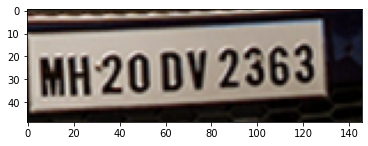

In [31]:
import matplotlib.pyplot as plt

carImg = cv2.imread("./Data/Car/car1.jpg")
cc = CascadeClassifier(carImg, 1.2)
cc.detect_cascade()
plate = cc.get_plate()
plt.imshow(plate)

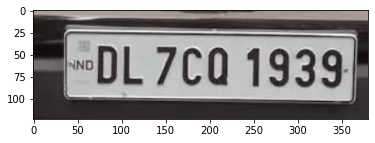

In [47]:
carPlateDirName = "./Car/CarPlate"
fileNames = os.listdir(carPlateDirName)
images = [ cv2.imread(os.path.join(carPlateDirName, i)) for i in fileNames ]
plt.imshow(images[0])
# images[0].show()

In [8]:
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [9]:
def remove_noise(image):
    return cv2.medianBlur(image, 5)

In [51]:
def thresholding(image):
    return cv2.threshold(image, 0, 255,  cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

In [11]:
def applyPreprocessing(image, preprocessors):
  for preprocessor in preprocessors:
    image = preprocessor(image)
  return image

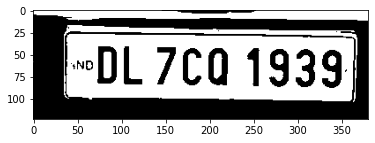

In [53]:
images = [ applyPreprocessing(image, [get_grayscale, thresholding]) for image in images ]
plt.imshow(images[0], cmap = "gray")

In [45]:
class ImageRecognizer:
    def __init__(self, image, *, psm=6, char_whitelist="ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"):
        self.image = image
        self.config = f"--psm {psm} tessedit_char_whitelist = {char_whitelist}"
        self.processed = False

    def recognize(self):
        self.boxes = pt.image_to_boxes(
            self.image, config=self.config, output_type=Output.DICT)
        self.data = pt.image_to_data(
            self.image, config=self.config, output_type=Output.DICT)
        self.text = pt.image_to_string(self.image, config=self.config)
        self.processed = True

    def get_text(self):
        if not self.processed:
            return False
        return self.text

    def get_boxes(self):
        if not self.processed:
            return False
        return self.boxes

    def get_data(self):
        if not self.processed:
            return False
        return self.data

In [27]:
NUMERPLATE_PATTERN=regex.compile(
    r"(([A-Z]\s*){2}([0-9]\s*){1,2}([A-Z]\s*){2}([0-9]\s*){1,4}){s<2}")
def get_numberplate_matches(text):
  matches = NUMERPLATE_PATTERN.findall(text)
  return matches

In [54]:
# plt.imshow(images[0])
for image in images:  
  ir = ImageRecognizer(image)
  ir.recognize()
  text = ir.get_text()
  matches = get_numberplate_matches(text)
  if not matches:
    print("No matches were found for the provided image")
  else:
    print("Match: ", matches[0][0].strip())

Match:  DL7C0 1933
No matches were found for the provided image
Match:  II TN 63
Match:  MH20EJ 0365
Match:  JO3ER0563
Match:  CGO4MF2250
Match:  HH12DE1433
Match:  KL 52 P_3003
Match:  SGIAZ7873
Match:  DL 2C K8169
